In [1]:
import scanpy as sc
import os
import pandas as pd
import decoupler as dc

In [2]:
adata = sc.read_h5ad("../../../data/integrated/plate_int.h5ad")
adata.var_names = adata.var.features

# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
adata

/opt/homebrew/Caskroom/miniforge/base/envs/ovisium/lib/python3.10/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 9129 × 5559
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Sample', 'plate', 'Confidence', 'PFI', 'patient', 'annotation_manual', 'B.cells_UCell', 'Cancer.cells_UCell', 'Dendritic.cells_UCell', 'Endothelial.cells_UCell', 'Fibroblasts_UCell', 'Meyloid.cells_UCell', 'T.cells_UCell', 'Ovarian.stromal.cells_UCell', 'Naturall.Killer.cells_UCell', 'Mast.cells_UCell', 'cell_type', 'seurat_clusters_old', 'PFI_confidence', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters'
    var: '_index', 'features'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

In [2]:
net_fp = os.path.join('../../../data/sc-data', 'ref_markers_cell_subtype.csv')
net = pd.read_csv(net_fp)

In [4]:
dc.decouple(adata, net = net, source = 'cell_type', weight = 'logFCs', methods = 'consensus', use_raw = False)

Running consensus.
Running mlm on mat with 9129 samples and 5559 targets for 21 sources.


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Running ulm on mat with 9129 samples and 5559 targets for 21 sources.
Running wsum on mat with 9129 samples and 5559 targets for 21 sources.
Infering activities on 1 batches.


100%|██████████| 1/1 [01:01<00:00, 61.81s/it]


In [20]:
acts = dc.get_acts(adata, obsm_key='consensus_estimate')


In [6]:
# pd.DataFrame(acts.X, index=acts.obs_names, columns=acts.var_names).to_csv('test.csv', sep=',')

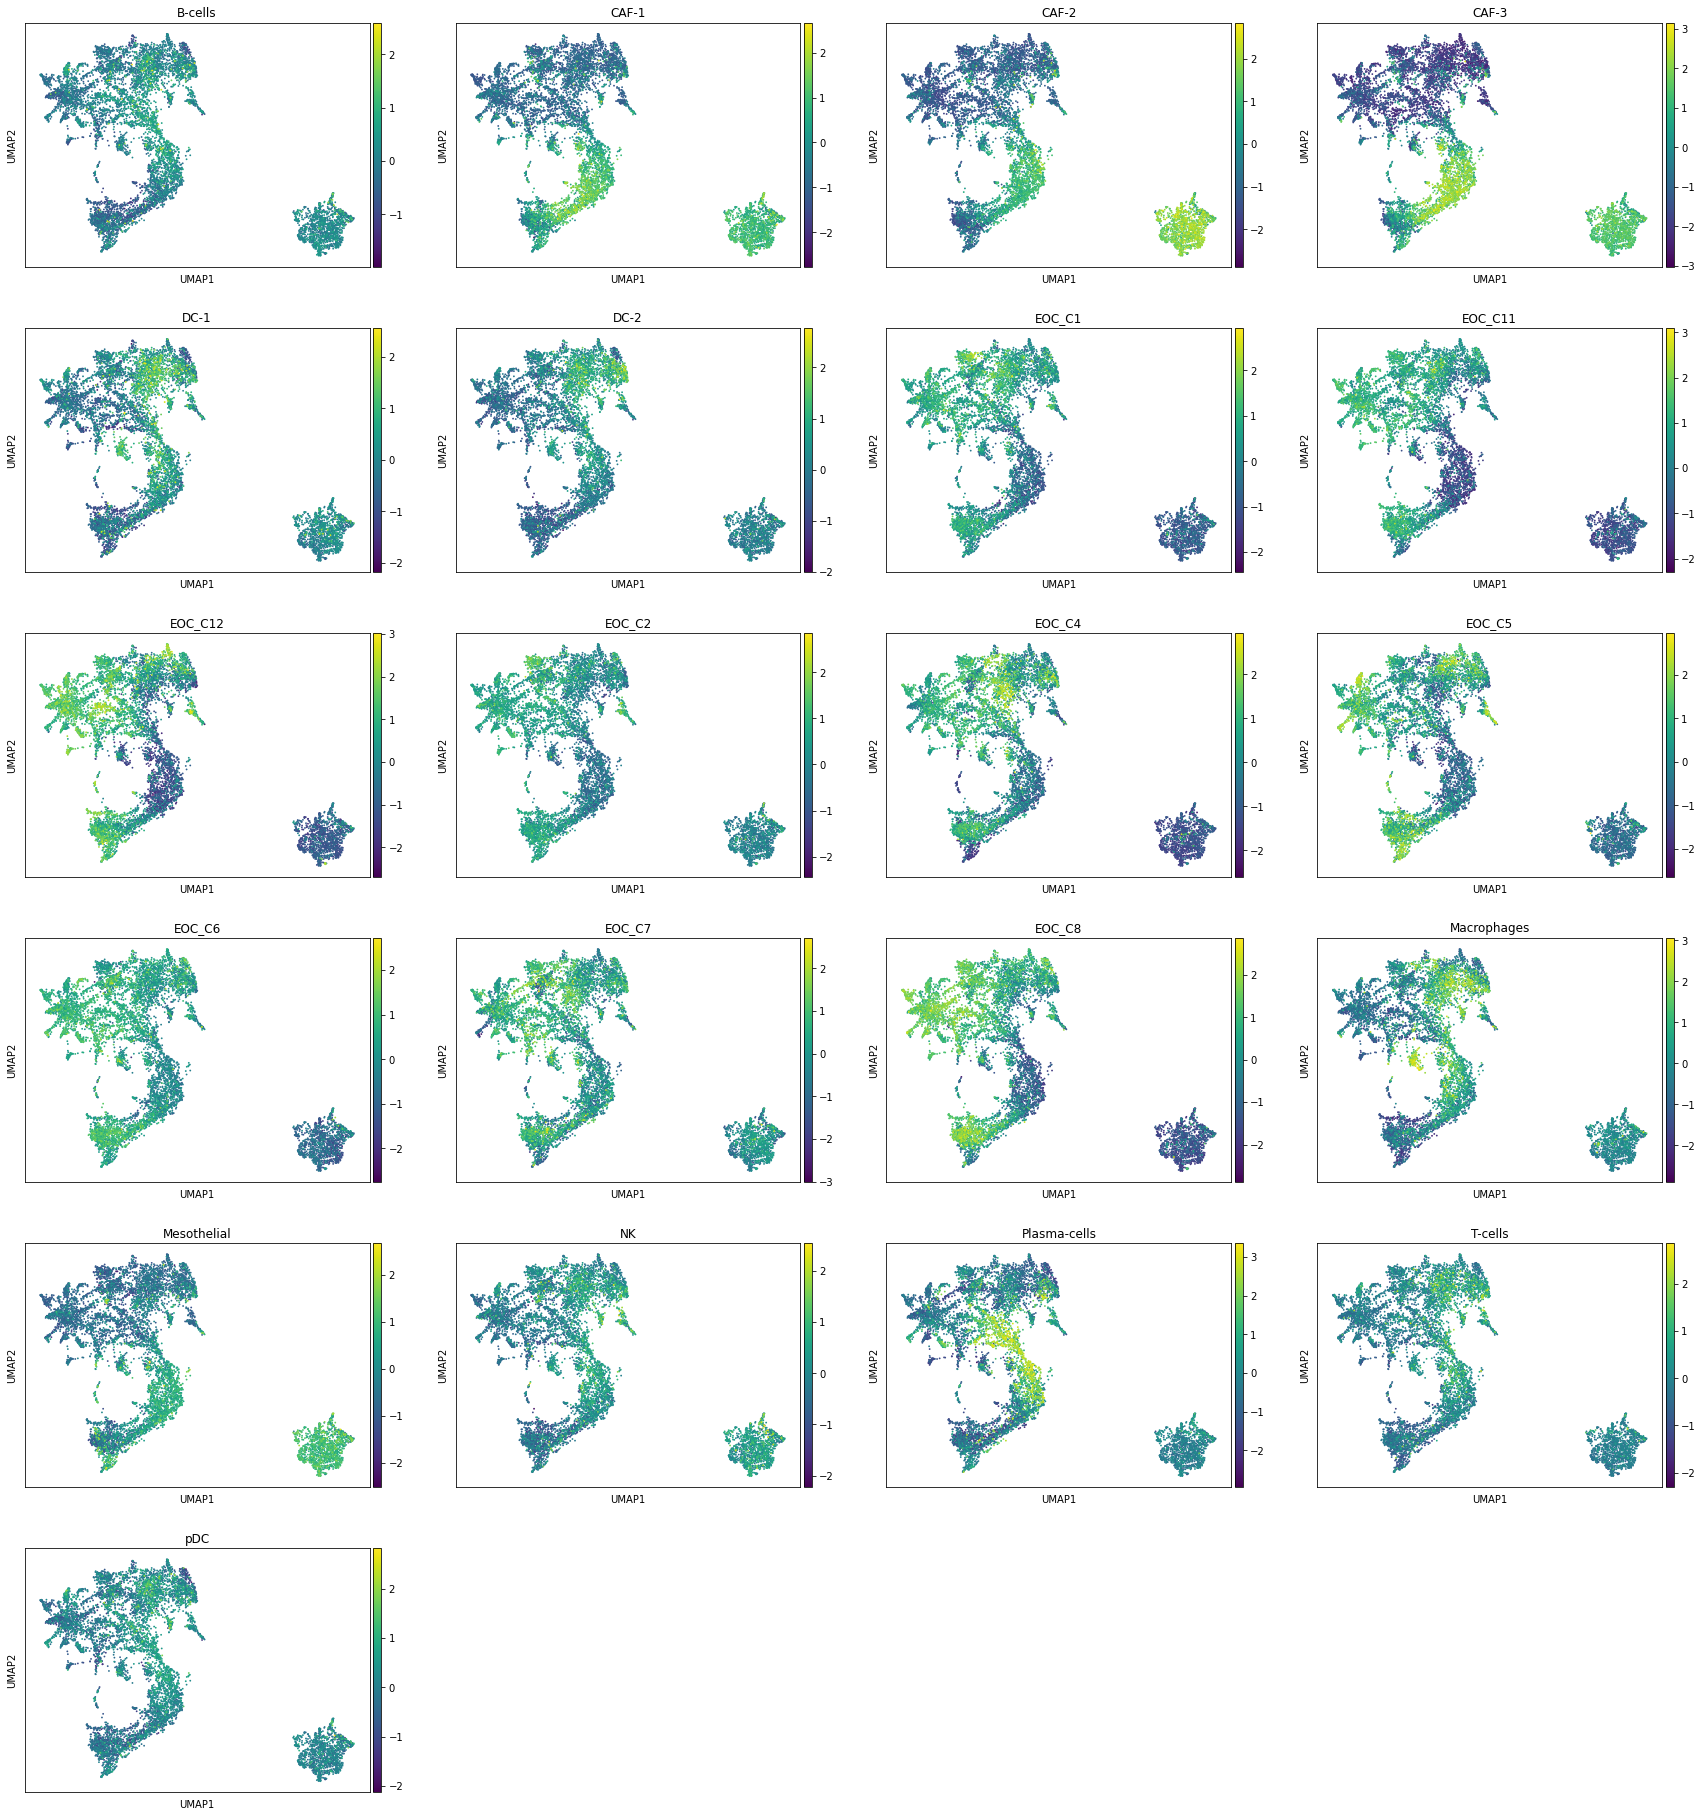

In [7]:
sc.pl.umap(acts, color=list(acts.var_names))

In [8]:
import numpy as np

In [9]:
def summarize_acts(acts, groupby, obs=None, mode='mean', min_std=1.0):
    """
    Summarizes activities obtained per group by their mean or median and removes features that do not change across samples.
    Parameters
    ----------
    acts : AnnData or DataFrame
        Activities obtained after running a method.
    groupby : str
        Column name of obs to use for grouping.
    obs : DataFrame
        None or a data-frame with sample meta-data.
    mode : str
        Wheter to use mean or median to summarize.
    min_std : float
        Minimum std to filter out features. Only features with enough variability will be returned. Decrease it to return more
        features.
    Returns
    -------
    summary : DataFrame
        Dataframe with summaried actvities per group.
    """

    # Extract acts, obs and features
    if type(acts) is sc.AnnData:
        if obs is not None:
            raise ValueError('If acts is AnnData, obs needs to be None.')
        obs = acts.obs[groupby].values.astype('U')
        features = acts.var.index.values.astype('U')
        acts = acts.X
    else:
        obs = obs[groupby].values.astype('U')
        features = acts.columns.astype('U')
        acts = acts.values

    # Get sizes
    groups = np.unique(obs)
    n_groups = len(groups)
    n_features = acts.shape[1]

    # Init empty mat
    summary = np.zeros((n_groups, n_features), dtype=np.float32)

    acts[np.isinf(acts)] = np.nan

    for i in range(n_groups):
        msk = obs == groups[i]
        if mode == 'mean':
            temp = acts[msk]
            summary[i] = np.mean(acts[msk], axis=0)
        elif mode == 'median':
            summary[i] = np.median(acts[msk], axis=0)
        else:
            raise ValueError('mode can only be either mean or median.')

    # Filter by min_std
    min_std = np.abs(min_std)
    msk = np.std(summary, axis=0, ddof=1) > min_std

    # Transform to df
    summary = pd.DataFrame(summary[:, msk], columns=features[msk], index=groups)

    return summary

In [23]:
keep = acts.obs.Confidence != 'Benign'
acts = acts[keep]
mean_enr = summarize_acts(acts, groupby='Sample', min_std=0)
mean_enr

/var/folders/vl/1y1qg3c911x2hvqbsl7zfpz40000gn/T/ipykernel_11553/3829560457.py:43: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  acts[np.isinf(acts)] = np.nan


,B-cells,CAF-1,CAF-2,CAF-3,DC-1,DC-2,EOC_C1,EOC_C11,EOC_C12,EOC_C2,...,EOC_C5,EOC_C6,EOC_C7,EOC_C8,Macrophages,Mesothelial,NK,Plasma-cells,T-cells,pDC
BG-L_OVA15-16,-0.473054,-0.840155,-0.634928,-0.823009,-0.029929,-0.311752,0.056018,0.690237,0.585127,0.153820,...,0.191444,0.358705,0.524640,1.021362,-0.417554,-0.655173,-0.703660,-0.700929,-0.381220,-0.517520
BG-L_OVA20,0.250147,-0.919338,-1.505223,-1.790861,-0.010907,-0.102042,0.986593,0.870129,1.094186,0.354508,...,1.827334,0.183634,0.038167,1.034152,-0.467038,-0.765625,-0.079111,-0.995530,0.197449,0.386154
BG-L_OVA22,0.213485,-0.679150,-0.599755,-0.907016,-0.254488,-0.023814,0.115356,0.274827,-0.193383,-0.182500,...,-0.794994,0.379622,0.017303,0.063419,-0.103032,-0.598454,-0.122683,1.699547,-0.022725,0.037962
BG-L_OVA23,-0.225168,-0.831353,-0.946561,-1.093057,-0.466112,-0.696432,0.000189,0.536045,0.637939,0.300411,...,1.791974,0.708802,-1.505499,1.320206,-0.396492,-0.909070,-0.349377,0.408403,-0.245581,0.274773
BG-L_OVA26,-0.068309,0.032497,-0.679191,0.069917,0.039104,0.113424,0.466548,-0.136833,-0.560766,-0.005130,...,-0.513131,-0.163516,0.039106,0.145242,0.352530,-0.497635,0.148725,-0.445562,0.080943,-0.104325
BG-L_OVA29,-0.056928,-0.555509,-0.767062,-1.056787,0.397461,0.507115,0.092048,-0.463678,0.133259,-0.603434,...,0.406989,0.134720,-0.102173,-0.021072,0.603248,0.091840,0.123039,-0.878843,0.272973,-0.108470
BG-L_OVA33,-0.556003,-0.013878,-1.080162,-0.132579,-0.221557,-0.481031,0.660995,0.848857,0.064812,0.117680,...,0.418008,0.826441,0.546189,1.275212,-0.245286,-0.764660,-0.626256,-1.627421,-0.271638,-0.375704
BG-L_OVA46,0.195867,-0.330109,-0.201067,-0.423022,-0.845051,-0.527044,-0.440305,0.527192,0.758855,0.418270,...,0.256241,0.490009,-0.013009,-0.185794,-1.131568,-0.061610,-0.567898,1.640935,-0.480314,0.056996
BG-S_OVA10,-0.569292,-0.106731,-0.956275,0.042901,-0.836091,-0.830459,0.738180,0.404988,0.432857,0.315116,...,0.013984,0.723462,0.459064,1.664853,-1.139875,-0.474340,-0.642631,-0.746113,-0.582496,-0.721671
BG-S_OVA12,-0.258667,-0.649775,-0.928278,-1.105770,-0.501828,-0.325210,-0.261387,0.078050,0.520672,0.037800,...,-0.077533,0.464355,-0.990615,0.386909,-0.867299,-0.719274,-0.275204,0.209423,-0.096218,-0.111014


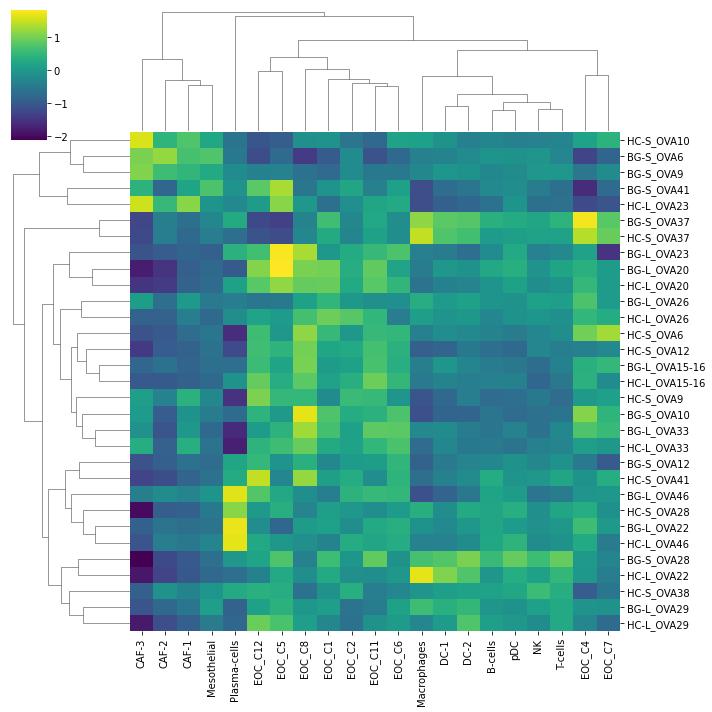

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()